# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
data = pd.read_csv('https://github.com/hse-ds/iad-intro-ds/raw/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv', encoding='latin-1')
data.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
10780,16884,61836,Toronto & Sudbury,21-03-2020,If shortages have forced you to turn to produc...,Negative
22528,31332,76284,City of Angels,03-04-2020,NEW w/@jtemplon @a_cormier_ : HereÃÂs How Th...,Positive
31809,42931,87883,India,12-04-2020,Indian-American 7-Eleven store owner was arres...,Negative
25787,35386,80338,NaN,07-04-2020,.@Uber lists job openings in delivery/food pro...,Positive
29083,39493,84445,"Chicago, IL",09-04-2020,??Casa Central is receiving donations of unuse...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
data['Sentiment'] = data['Sentiment'].apply(lambda x: 1 if 'Positive' in x else 0)

Сбалансированы ли классы?

In [4]:
sentiment_counts = data['Sentiment'].value_counts()
print("Количество твиттов с положительной эмоциональной окраской (1):", sentiment_counts[1])
print("Количество твиттов с отрицательной эмоциональной окраской (0):", sentiment_counts[0])

Количество твиттов с положительной эмоциональной окраской (1): 18046
Количество твиттов с отрицательной эмоциональной окраской (0): 15398


**Ответ:** Классы не максимально сбалансированы, так как соотношение не 1 к 1, но достаточно хорошо сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [5]:
print(data.isnull().sum())
data.fillna('Unknown', inplace=True)

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

train['OriginalTweet'] = train['OriginalTweet'].str.lower()
corpus = ' '.join(train['OriginalTweet'])

tokens = word_tokenize(corpus)
token_counts = Counter(tokens)

Какой размер словаря получился?

In [8]:
print(len(token_counts))

57432


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [9]:
top_10_tokens = token_counts.most_common(10)
for token, count in top_10_tokens:
    print(f"Токен: {token}, Количество упоминаний: {count}")

Токен: #, Количество упоминаний: 42753
Токен: the, Количество упоминаний: 26928
Токен: to, Количество упоминаний: 23466
Токен: ., Количество упоминаний: 22529
Токен: ,, Количество упоминаний: 17556
Токен: :, Количество упоминаний: 16478
Токен: and, Количество упоминаний: 14792
Токен: of, Количество упоминаний: 13042
Токен: https, Количество упоминаний: 12921
Токен: a, Количество упоминаний: 11833


**Ответ:** все эти токены - знаки препинания, предлоги и начало ссылок(https)

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [10]:
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
filtered_token_counts = {token: count for token, count in token_counts.items() if token not in stop_words}
top_10_filtered_tokens = Counter(filtered_token_counts).most_common(10)
for token, count in top_10_filtered_tokens:
    print(f"Токен: {token}, Количество упоминаний: {count}")

Токен: #, Количество упоминаний: 42753
Токен: ., Количество упоминаний: 22529
Токен: ,, Количество упоминаний: 17556
Токен: :, Количество упоминаний: 16478
Токен: https, Количество упоминаний: 12921
Токен: ?, Количество упоминаний: 11033
Токен: coronavirus, Количество упоминаний: 9964
Токен: @, Количество упоминаний: 9959
Токен: !, Количество упоминаний: 4700
Токен: prices, Количество упоминаний: 4614


**Ответ:**  теперь это знаки препинания

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [11]:
bottom_20_tokens = Counter(filtered_token_counts).most_common()[-20:]
for token, count in bottom_20_tokens:
    print(f"Токен: {token}, Количество упоминаний: {count}")

Токен: //t.co/lw1r0rm7xs, Количество упоминаний: 1
Токен: //t.co/5cbliqzx7l, Количество упоминаний: 1
Токен: now.when, Количество упоминаний: 1
Токен: milion, Количество упоминаний: 1
Токен: skellig, Количество упоминаний: 1
Токен: skelligsix18, Количество упоминаний: 1
Токен: skelligcoast2kms, Количество упоминаний: 1
Токен: southkerry, Количество упоминаний: 1
Токен: //t.co/zjcl195vqs, Количество упоминаний: 1
Токен: srinivasiyc, Количество упоминаний: 1
Токен: //t.co/iaek4fwsgz, Количество упоминаний: 1
Токен: premiership, Количество упоминаний: 1
Токен: non-playing, Количество упоминаний: 1
Токен: subsidise, Количество упоминаний: 1
Токен: playersãâ, Количество упоминаний: 1
Токен: renewing, Количество упоминаний: 1
Токен: flew, Количество упоминаний: 1
Токен: torontopearson, Количество упоминаний: 1
Токен: 680news, Количество упоминаний: 1
Токен: //t.co/7j2y3rsld9, Количество упоминаний: 1


**Ответ:** это либо ссылки(например, //t.co/lw1r0rm7xs), либо опечатки (milion, например), либо просто редкие слова(playersã), либо отсутстие пробела(или между двумя словами точка)
Надо постараться убрать ссылки (в них нет смысла) и избавиться от опечаток и прочих грамматических ошибок.

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [12]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
tokens_tweet = tokenizer.tokenize(corpus)
token_counts_tweet = Counter(tokens_tweet)
top_10_tokens_tweet = token_counts_tweet.most_common(10)
for token, count in top_10_tokens_tweet:
    print(f"Токен: {token}, Количество упоминаний: {count}")

Токен: the, Количество упоминаний: 26993
Токен: ., Количество упоминаний: 24108
Токен: to, Количество упоминаний: 23478
Токен: ,, Количество упоминаний: 17571
Токен: and, Количество упоминаний: 14825
Токен: of, Количество упоминаний: 13044
Токен: a, Количество упоминаний: 11891
Токен: in, Количество упоминаний: 11348
Токен: ?, Количество упоминаний: 9524
Токен: #coronavirus, Количество упоминаний: 8808


**Ответ:** Теперь нет знака хэштэга (это объясняется тем, что токенайзер обучен на данных по Твиттеру, а там хэштеги очень популярны), знаков препинания стало меньше (хотя точка, запятая и знак вопроса), нет https(полагаю, токенайзер обучен так, что это часть ссылки), и 'coronavirus' объединился с хэштегом.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [13]:
from string import punctuation

stop_words = set(stopwords.words('english'))
filtered_token_counts_tweet = {token: count for token, count in token_counts_tweet.items() 
                               if token.lower() not in stop_words and token not in punctuation}
top_10_filtered_tokens_tweet = Counter(filtered_token_counts_tweet).most_common(10)
for token, count in top_10_filtered_tokens_tweet:
    print(f"Токен: {token}, Количество встреч: {count}")

Токен: #coronavirus, Количество встреч: 8808
Токен: â, Количество встреч: 7415
Токен: , Количество встреч: 7311
Токен: 19, Количество встреч: 7167
Токен: covid, Количество встреч: 6253
Токен: prices, Количество встреч: 4601
Токен: , Количество встреч: 4372
Токен: food, Количество встреч: 4367
Токен: store, Количество встреч: 3877
Токен: supermarket, Количество встреч: 3805


**Ответ:** Слова появились, но остались 19, эмодзи (как я понял, это они не распознаются) и буква â (она не английская, поэтому ее нет в стоп-словах)

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [14]:
filtered_token_counts_tweet = {token: count for token, count in filtered_token_counts_tweet.items() 
                               if len(token) > 1 or all(ord(char) < 128 for char in token)}

top_10_filtered_tokens_tweet = Counter(filtered_token_counts_tweet).most_common(10)
print("Топ-10 самых популярных слов:")
for token, count in top_10_filtered_tokens_tweet:
    print(f"Токен: {token}, Количество встреч: {count}")

Топ-10 самых популярных слов:
Токен: #coronavirus, Количество встреч: 8808
Токен: 19, Количество встреч: 7167
Токен: covid, Количество встреч: 6253
Токен: prices, Количество встреч: 4601
Токен: food, Количество встреч: 4367
Токен: store, Количество встреч: 3877
Токен: supermarket, Количество встреч: 3805
Токен: grocery, Количество встреч: 3523
Токен: people, Количество встреч: 3463
Токен: #covid19, Количество встреч: 2589


In [15]:
bottom_20_filtered_tokens_tweet = Counter(filtered_token_counts_tweet).most_common()[-20:]
print("Топ-20 самых непопулярных слов:")
for token, count in bottom_20_filtered_tokens_tweet:
    print(f"Токен: {token}, Количество встреч: {count}")

Топ-20 самых непопулярных слов:
Токен: https://t.co/lw1r0rm7xs, Количество встреч: 1
Токен: https://t.co/5cbliqzx7l, Количество встреч: 1
Токен: now.when, Количество встреч: 1
Токен: milion, Количество встреч: 1
Токен: skellig, Количество встреч: 1
Токен: @skelligsix18, Количество встреч: 1
Токен: #skelligcoast2kms, Количество встреч: 1
Токен: #southkerry, Количество встреч: 1
Токен: https://t.co/zjcl195vqs, Количество встреч: 1
Токен: @srinivasiyc, Количество встреч: 1
Токен: https://t.co/iaek4fwsgz, Количество встреч: 1
Токен: premiership, Количество встреч: 1
Токен: non-playing, Количество встреч: 1
Токен: subsidise, Количество встреч: 1
Токен: playersã, Количество встреч: 1
Токен: renewing, Количество встреч: 1
Токен: flew, Количество встреч: 1
Токен: @torontopearson, Количество встреч: 1
Токен: @680news, Количество встреч: 1
Токен: https://t.co/7j2y3rsld9, Количество встреч: 1


**Ответ:** топ-10 стали еще лучше! там теперь только слова, хэштеги и '19'!, а топ-20 тоже лучше стал, так как некоторые слова дополнились знаком '#', а упомянутые аккаунты дополнились '@'. 

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [16]:
hashtag_counts = {}

for token, count in token_counts_tweet.items():
    if token.startswith('#'):
        hashtag_counts[token] = count

top_10_hashtags = Counter(hashtag_counts).most_common(10)
print("Топ-10 популярных хэштегов:")
for hashtag, count in top_10_hashtags:
    print(f"Хэштег: {hashtag}, Количество встреч: {count}")



Топ-10 популярных хэштегов:
Хэштег: #coronavirus, Количество встреч: 8808
Хэштег: #covid19, Количество встреч: 2589
Хэштег: #covid_19, Количество встреч: 1734
Хэштег: #covid2019, Количество встреч: 946
Хэштег: #toiletpaper, Количество встреч: 744
Хэштег: #covid, Количество встреч: 641
Хэштег: #socialdistancing, Количество встреч: 465
Хэштег: #coronacrisis, Количество встреч: 448
Хэштег: #pandemic, Количество встреч: 257
Хэштег: #coronaviruspandemic, Количество встреч: 249


**Ответ:** 8 из них напрямую связаны с пандемией/коронавирусом. #socialdistancing связан с популяризацией соблюдения дистанции с целью борьбы с распространением вируса, а #toiletpaper, полагаю, связан с дефицитом туалетной бумаги из-за паники в начале пандемии.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [17]:
link_counts = {}
for token, count in token_counts_tweet.items():
    if token.startswith('https://t.co'):
        link_counts[token] = count

top_10_links = Counter(link_counts).most_common(10)
print("Топ-10 популярных ссылок на сайт 'https://t.co:''")
for link, count in top_10_links:
    print(f"Ссылка: {link}, Количество встреч: {count}")

Топ-10 популярных ссылок на сайт 'https://t.co:''
Ссылка: https://t.co/oxa7swtond, Количество встреч: 5
Ссылка: https://t.co/gp3eusapl8, Количество встреч: 4
Ссылка: https://t.co/deftrui1pfãâ, Количество встреч: 3
Ссылка: https://t.co/wrlhyzizaa, Количество встреч: 3
Ссылка: https://t.co/kuwipf1kqw, Количество встреч: 3
Ссылка: https://t.co/zjnrx6dkkn, Количество встреч: 3
Ссылка: https://t.co/3gbbdpdjat, Количество встреч: 3
Ссылка: https://t.co/e2znxajpre, Количество встреч: 3
Ссылка: https://t.co/catkegayoy, Количество встреч: 3
Ссылка: https://t.co/g63rp042ho, Количество встреч: 3


**Ответ:** Подобные ссылки нам не нужны, они вообще не популярны и не ведут на какой-то сайт(как я понял, это ссылки на твиты, которых уже нет)

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [18]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from string import punctuation

def custom_tokenizer(text):
    text = text.lower()
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in punctuation]    
    tokens = [token for token in tokens if not token.startswith('https://t.co')]
    tokens = [token for token in tokens if (len(token) > 1 or all(ord(char) < 128 for char in token))]
    return tokens

In [19]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
tweet_corpus = train['OriginalTweet']
X = cv.fit_transform(train['OriginalTweet'])
print(len(cv.vocabulary_))

/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** Размер словаря сильно меньше, чем был изначально. Это объясняется тем, что мы почистили словарь от пунктуации, стоп-слов, ссылок и слов из одной буквы с ord >= 128

Посмотрим на какой-нибудь конкретный твитт:

In [21]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('nice one @skynews lets not panic but show ppl in france queueing for food!!! #coronavirusoutbreak #covid2019 brainless!! ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [22]:
ind = 9023
tweet_text = train.iloc[ind]['OriginalTweet']
tweet_vector = cv.transform([tweet_text])

print(tweet_vector)
max_index = tweet_vector.argmax()
min_index = tweet_vector.argmin()
max_token = list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(max_index)]
min_token = list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(min_index)]

max_token, min_token


  (0, 1833)	1
  (0, 2046)	1
  (0, 16658)	1
  (0, 20553)	1
  (0, 26665)	1
  (0, 27042)	1
  (0, 27233)	1
  (0, 31579)	1
  (0, 34079)	1
  (0, 34688)	1
  (0, 35257)	1
  (0, 36413)	1
  (0, 37229)	1
  (0, 39919)	1


('#coronavirusoutbreak', '###covid-19')

**Ответ:** Важность токенов вообще не определилась, потому что он считал частоту токенов в этом тексте, и просто получается, что каждое слово упомянуты по разу, а значит все они равны по важности.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
X_tfidf = tfidf_vectorizer.fit_transform(train['OriginalTweet'])
tweet_tfidf_vector = tfidf_vectorizer.transform([tweet_text])
print(tweet_tfidf_vector)
max_index_tfidf = tweet_tfidf_vector.argmax()
min_index_tfidf = tweet_tfidf_vector.argmin()
max_token_tfidf = list(tfidf_vectorizer.vocabulary_.keys())[list(tfidf_vectorizer.vocabulary_.values()).index(max_index_tfidf)]
min_token_tfidf = list(tfidf_vectorizer.vocabulary_.keys())[list(tfidf_vectorizer.vocabulary_.values()).index(min_index_tfidf)]

max_token_tfidf, min_token_tfidf


  (0, 39919)	0.24406492401820118
  (0, 37229)	0.35434556333216544
  (0, 36413)	0.2550064610386691
  (0, 35257)	0.14759470306326164
  (0, 34688)	0.16306722855395073
  (0, 34079)	0.2542729176022132
  (0, 31579)	0.30121070136861045
  (0, 27233)	0.32047314046539654
  (0, 27042)	0.11328893069250721
  (0, 26665)	0.3244741764513268
  (0, 20553)	0.3867641170466375
  (0, 16658)	0.31042634466284263
  (0, 2046)	0.16825192939361902
  (0, 1833)	0.22584265007428544


('brainless', '###covid-19')

**Ответ:** Здесь важность гораздо лучше определилась, потому что TF-IDF считает не только по данному твиту, но и по совокупности всех текстов.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [24]:
positive_tweets_with_great = train[train['OriginalTweet'].apply(lambda x: 'amazing' in x.lower()) & (train['Sentiment'] == 1)]
from sklearn.feature_extraction.text import TfidfVectorizer
positive_tweet = positive_tweets_with_great.iloc[3]['OriginalTweet']
print(positive_tweet)
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
X_tfidf = tfidf_vectorizer.fit_transform(tweet_corpus)
tweet_tfidf_vector = tfidf_vectorizer.transform([positive_tweet])
print(tweet_tfidf_vector)
max_index_tfidf = tweet_tfidf_vector.argmax()
max_token_tfidf = list(tfidf_vectorizer.vocabulary_.keys())[list(tfidf_vectorizer.vocabulary_.values()).index(max_index_tfidf)]
max_token_tfidf


let s just take a minute to say thank you also to the amazing postal workers so many real people behind a click of online shopping and getting cards delivered thank   you   19
  (0, 44921)	0.1514104788394431
  (0, 42251)	0.3691299729428483
  (0, 41881)	0.17642821335223333
  (0, 39863)	0.13967487683042282
  (0, 39117)	0.20055018776835395
  (0, 37556)	0.21925345625365103
  (0, 36334)	0.2993677027383562
  (0, 35628)	0.11898135781908498
  (0, 34714)	0.1423478833529413
  (0, 33093)	0.29447593282367407
  (0, 32407)	0.1705077944503823
  (0, 31573)	0.21263423966251038
  (0, 27756)	0.19726227818071368
  (0, 23951)	0.25775545309252745
  (0, 22051)	0.25686716144204225
  (0, 21263)	0.2809984803053545
  (0, 19901)	0.25431735632719876
  (0, 18544)	0.2500353203109799
  (0, 18505)	0.17861928808211908
  (0, 10262)	0.08634631973114963


'thank'

**Ответ:** здесь слово 'thank' самое важное за счет того, что упомянуто дважды, но оно все равно очень помогает определить окраску твита, так как в нем благодарят работников, что очень даже положительно;)

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [25]:
count_vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
tweet_corpus_train = tweet_corpus
X_count_train = count_vectorizer.fit_transform(tweet_corpus_train)
X_tfidf_train = tfidf_vectorizer.fit_transform(tweet_corpus_train)
y_train = train['Sentiment'].values

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [26]:
tweet_corpus_test = test['OriginalTweet']
X_count_test = count_vectorizer.transform(tweet_corpus_test)
X_tfidf_test = tfidf_vectorizer.transform(tweet_corpus_test)
y_test = test['Sentiment'].values

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


logreg_count = LogisticRegression()
logreg_count.fit(X_count_train, y_train)
logreg_tfidf = LogisticRegression()
logreg_tfidf.fit(X_tfidf_train, y_train)

y_count_train_pred = logreg_count.predict(X_count_train)
y_count_test_pred = logreg_count.predict(X_count_test)
y_tfidf_train_pred = logreg_tfidf.predict(X_tfidf_train)
y_tfidf_test_pred = logreg_tfidf.predict(X_tfidf_test)

train_accuracy_count = accuracy_score(y_train, y_count_train_pred)
test_accuracy_count = accuracy_score(y_test, y_count_test_pred)
train_accuracy_tfidf = accuracy_score(y_train, y_tfidf_train_pred)
test_accuracy_tfidf = accuracy_score(y_test, y_tfidf_test_pred)

print("Accuracy для CountVectorizer (обучающая выборка):", train_accuracy_count)
print("Accuracy для CountVectorizer (тестовая выборка):", test_accuracy_count)
print("Accuracy для TfidfVectorizer (обучающая выборка):", train_accuracy_tfidf)
print("Accuracy для TfidfVectorizer (тестовая выборка):", test_accuracy_tfidf)

/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy для CountVectorizer (обучающая выборка): 0.9844510892780863
Accuracy для CountVectorizer (тестовая выборка): 0.8674506677297189
Accuracy для TfidfVectorizer (обучающая выборка): 0.9254592054677488
Accuracy для TfidfVectorizer (тестовая выборка): 0.8531991229818616


**Ответ:** Count Vectorizer показал лучший результат на обеих выборках. TF_IDF более сложная модель, и, казалось бы, должна работать лучше, потому что она не дает одинаковые веса всем словам, но получается, что в данной ситуации так не работает, и более простой Count Vectorizer показал бОльшую точность. 

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [28]:
from nltk.stem import SnowballStemmer

def custom_stem_tokenizer(text):
    text = text.lower()
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation and (len(token) > 1 or all(ord(char) < 128 for char in token)) and not token.startswith('https://t.co')]
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens


In [29]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [30]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tweet_corpus_train = train['OriginalTweet']
X_count_train = cv.fit_transform(train['OriginalTweet'])
print(len(cv.vocabulary_))

/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


In [31]:
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
X_tfidf_train = tfidf.fit_transform(train['OriginalTweet'])

**Ответ** размер словаря снизился, потому что теперь больше нет однокоренных слов.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [32]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tweet_corpus_train = train['OriginalTweet']
X_count_train = cv.fit_transform(train['OriginalTweet'])
X_tfidf_train = tfidf.fit_transform(train['OriginalTweet'])
y_train = train['Sentiment'].values
tweet_corpus_test = test['OriginalTweet']
X_count_test = cv.transform(tweet_corpus_test)
X_tfidf_test = tfidf.transform(tweet_corpus_test)
y_test = test['Sentiment'].values

logreg_count = LogisticRegression()
logreg_count.fit(X_count_train, y_train)
logreg_tfidf = LogisticRegression()
logreg_tfidf.fit(X_tfidf_train, y_train)

y_count_train_pred = logreg_count.predict(X_count_train)
y_count_test_pred = logreg_count.predict(X_count_test)
y_tfidf_train_pred = logreg_tfidf.predict(X_tfidf_train)
y_tfidf_test_pred = logreg_tfidf.predict(X_tfidf_test)

train_accuracy_count_1 = accuracy_score(y_train, y_count_train_pred)
test_accuracy_count_1 = accuracy_score(y_test, y_count_test_pred)
train_accuracy_tfidf_1 = accuracy_score(y_train, y_tfidf_train_pred)
test_accuracy_tfidf_1 = accuracy_score(y_test, y_tfidf_test_pred)

print("Accuracy для CountVectorizer (обучающая выборка):", train_accuracy_count_1)
print("Accuracy для CountVectorizer (тестовая выборка):", test_accuracy_count_1)
print("Accuracy для TfidfVectorizer (обучающая выборка):", train_accuracy_tfidf_1)
print("Accuracy для TfidfVectorizer (тестовая выборка):", test_accuracy_tfidf_1)

/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy для CountVectorizer (обучающая выборка): 0.9717642033319095
Accuracy для CountVectorizer (тестовая выборка): 0.8674506677297189
Accuracy для TfidfVectorizer (обучающая выборка): 0.9158906450234943
Accuracy для TfidfVectorizer (тестовая выборка): 0.8560892963922663


 **Ответ:** У CV точность упала на обучающей, и вообще не поменялась на тестовой. У TD-IDF на обучающей тоже упала, а на тестовой выросла на 0.003

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [33]:
max_df = 0.33
while True:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=max_df).fit(tweet_corpus_train)
    vocab_size = len(cv_df.vocabulary_)
    if vocab_size < 36651:
        break
    print(max_df, vocab_size)
    max_df -= 0.01

print("Размер словаря:", vocab_size, max_df)

cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=max_df).fit(tweet_corpus_train)
print(len(cv_df.vocabulary_))

/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.33 36651
0.32 36651
0.31 36651
0.3 36651
Размер словаря: 36650 0.29
36650


In [34]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=max_df+0.01).fit(tweet_corpus_train)
print(len(cv_df.vocabulary_))

36651


In [35]:
print(round(max_df+0.01, 2))

0.3


**Ответ:** Только 1 слово (не из стоп-слов при этом) упоминается в более чем 30% текстов. Думаю, это очень много, и объясняется это тем, что большая их часть связана одной темой - коронавирусом

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [36]:
min_df = 0.00043
while True:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=min_df).fit(tweet_corpus_train)
    vocab_size = len(cv_df.vocabulary_)
    if vocab_size < 3700:
        break
    print(min_df, vocab_size)
    min_df += 0.00001

print("Размер словаря:", vocab_size, min_df)

0.00043 3700
0.00044 3700
0.00045000000000000004 3700
0.00046000000000000007 3700
Размер словаря: 3489 0.0004700000000000001


In [37]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=min_df-0.00001)
X_count_train = cv_df.fit_transform(train['OriginalTweet'])
y_train = train['Sentiment'].values
tweet_corpus_test = test['OriginalTweet']
X_count_test = cv_df.transform(tweet_corpus_test)
y_test = test['Sentiment'].values

logreg_count = LogisticRegression()
logreg_count.fit(X_count_train, y_train)

y_count_train_pred = logreg_count.predict(X_count_train)
y_count_test_pred = logreg_count.predict(X_count_test)

train_accuracy_count = accuracy_score(y_train, y_count_train_pred)
test_accuracy_count = accuracy_score(y_test, y_count_test_pred)

print("Accuracy для CountVectorizer (обучающая выборка):", train_accuracy_count)
print("Accuracy для CountVectorizer (тестовая выборка):", test_accuracy_count)


Accuracy для CountVectorizer (обучающая выборка): 0.9284493806065783
Accuracy для CountVectorizer (тестовая выборка): 0.8677496511859677


/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Ответ:** у нас есть 3700 слов встречаются более чем в 0.046% твитов, и точность на тестовой выросла.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy для CountVectorizer (обучающая выборка): 0.9416915847928236
Accuracy для CountVectorizer (тестовая выборка): 0.8447279250548136


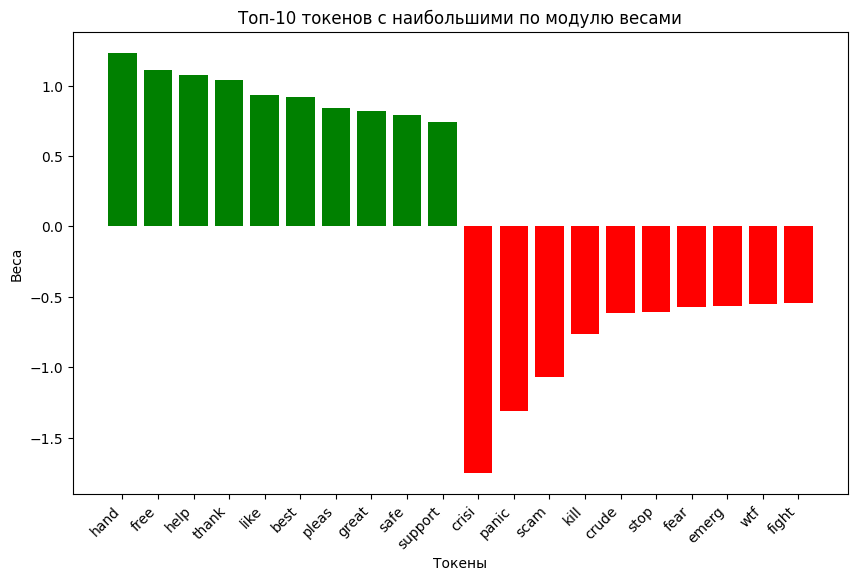

In [38]:
from sklearn.preprocessing import StandardScaler


min_df = 0.00044
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=min_df)

X_count_train = cv_df.fit_transform(train['OriginalTweet'])
X_count_test = cv_df.transform(tweet_corpus_test)

scaler = StandardScaler(with_mean=False)

X_count_train_scaled = scaler.fit_transform(X_count_train)
X_count_test_scaled = scaler.transform(X_count_test)

logreg_count_scaled = LogisticRegression()
logreg_count_scaled.fit(X_count_train_scaled, y_train)
y_count_train_pred = logreg_count_scaled.predict(X_count_train_scaled)
y_count_test_pred = logreg_count_scaled.predict(X_count_test_scaled)

train_accuracy_count = accuracy_score(y_train, y_count_train_pred)
test_accuracy_count = accuracy_score(y_test, y_count_test_pred)

print("Accuracy для CountVectorizer (обучающая выборка):", train_accuracy_count)
print("Accuracy для CountVectorizer (тестовая выборка):", test_accuracy_count)

coefficients = logreg_count_scaled.coef_[0]

vocab = {word: coef for word, coef in zip(cv_df.get_feature_names_out(), coefficients)}
positive_tokens = [(token, weight) for token, weight in vocab.items() if weight > 0]
negative_tokens = [(token, weight) for token, weight in vocab.items() if weight < 0]

top_positive_tokens = sorted(positive_tokens, key=lambda x: abs(x[1]), reverse=True)[:10]
top_negative_tokens = sorted(negative_tokens, key=lambda x: abs(x[1]), reverse=True)[:10]

tokens = [token for token, _ in top_positive_tokens + top_negative_tokens]
weights = [weight for _, weight in top_positive_tokens + top_negative_tokens]
colors = ['green' if weight > 0 else 'red' for weight in weights]

plt.figure(figsize=(10, 6))
plt.bar(tokens, weights, color=colors)
plt.xlabel('Токены')
plt.ylabel('Веса')
plt.title('Топ-10 токенов с наибольшими по модулю весами')
plt.xticks(rotation=45, ha='right')
plt.show()

**Ответ:** точность упала на тестовой выборке, а на обучающей выросла.

Самые топовые по положительные весам слова - это позитивные слова, часто упоминаемые: помощь, спасибо, лучший и тд. А по отрицательным - негативные: кризис, паника, скам, страх, втф и тд.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

**Ответ:** они вообще бесполезны, номера пользователей не могут нам дать ничего

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

/var/folders/7z/jt8zyxld0tn8ynqb4xjzv_lm0000gn/T/ipykernel_47752/1923846521.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  train['TweetAt'] = pd.to_datetime(train['TweetAt'])


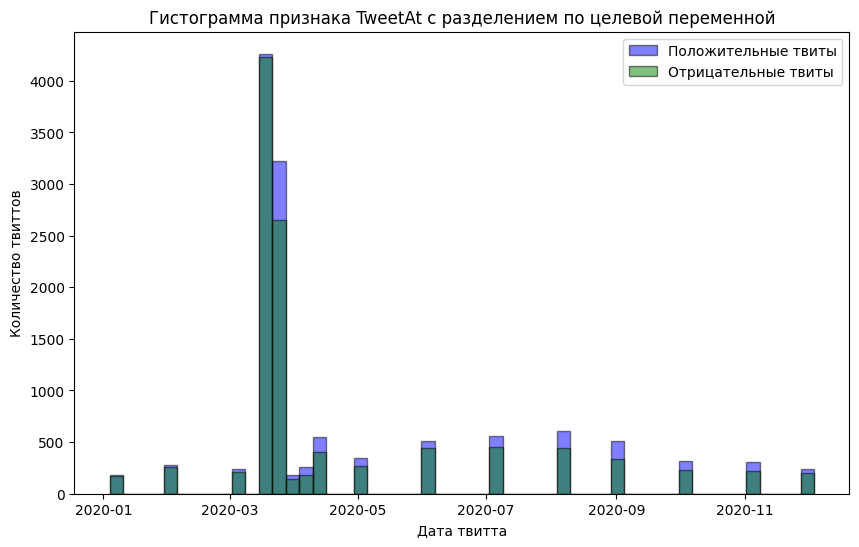

In [39]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'])
positive_tweets = train[train['Sentiment'] == 1]
negative_tweets = train[train['Sentiment'] == 0]

plt.figure(figsize=(10, 6))
plt.hist(positive_tweets['TweetAt'], bins=52, alpha=0.5, color='blue', label='Положительные твиты', edgecolor='black')
plt.hist(negative_tweets['TweetAt'], bins=52, alpha=0.5, color='green', label='Отрицательные твиты', edgecolor='black')
plt.title('Гистограмма признака TweetAt с разделением по целевой переменной')
plt.xlabel('Дата твитта')
plt.ylabel('Количество твиттов')
plt.legend()
plt.show()


**Ответ:** как можно увидеть, разницы особой нет: почти всегда положительных твитов немного больше, чем отрицательных, и это не очень зависит от даты. Поэтому пытаться закодировать этот признак не имеет особо смысла.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [40]:
unique_locations = train['Location'].nunique()
print(unique_locations)

7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

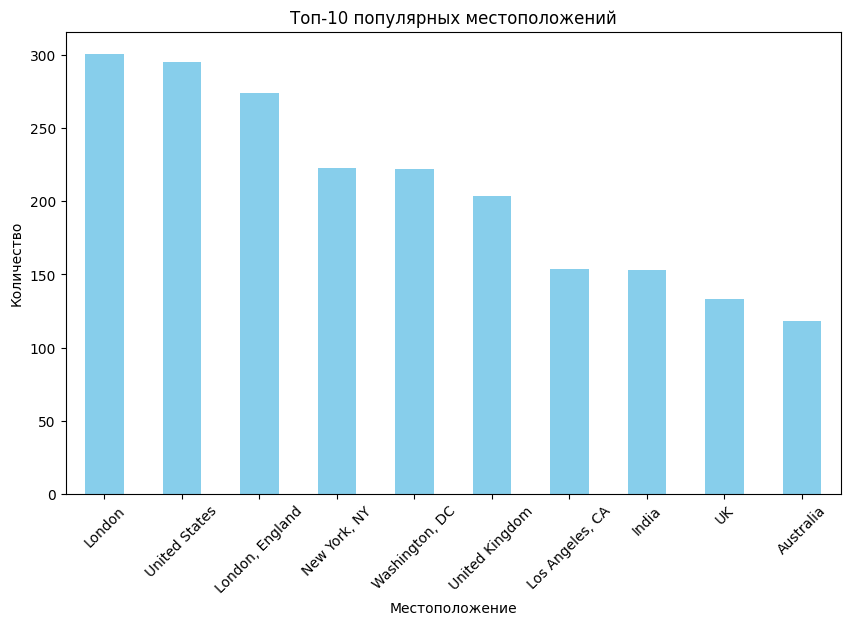

In [41]:
import matplotlib.pyplot as plt

location_counts = train[train['Location'] != 'Unknown']['Location'].value_counts()

top_10_locations = location_counts.head(10)

plt.figure(figsize=(10, 6))
top_10_locations.plot(kind='bar', color='skyblue')
plt.title('Топ-10 популярных местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()


Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

Уникальных категорий в признаке WiderLocation: 4766


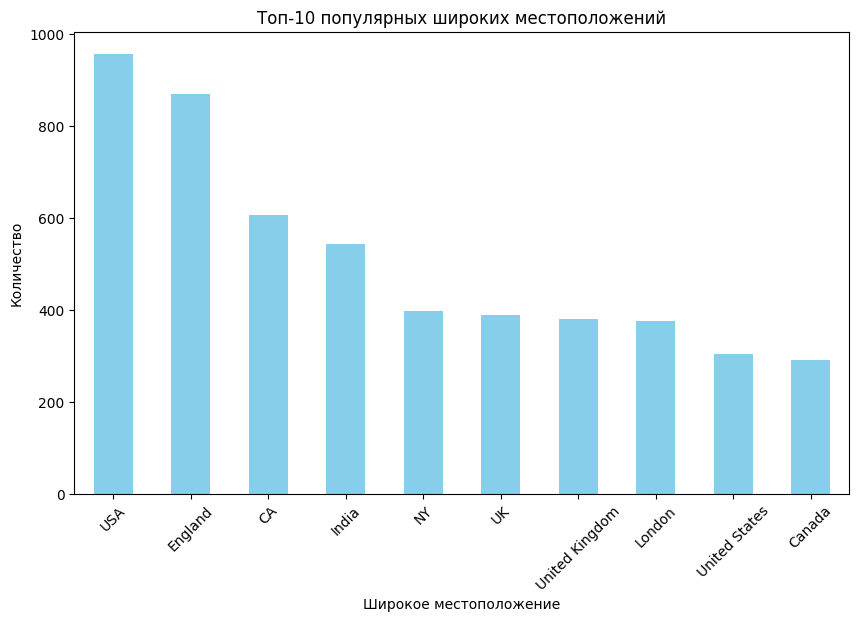

In [42]:
def extract_wider_location(location):
    if ',' in location:
        return location.split(',')[-1].strip()
    else:
        return location

train['WiderLocation'] = train['Location'].apply(extract_wider_location)
test['WiderLocation'] = test['Location'].apply(extract_wider_location)

unique_wider_locations = train['WiderLocation'].nunique()
print("Уникальных категорий в признаке WiderLocation:", unique_wider_locations)

wider_location_counts = train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts().head(10)

plt.figure(figsize=(10, 6))
wider_location_counts.plot(kind='bar', color='skyblue')
plt.title('Топ-10 популярных широких местоположений')
plt.xlabel('Широкое местоположение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [45]:
from sklearn.preprocessing import OneHotEncoder

wider_location_value_counts = train['WiderLocation'].value_counts()
frequent_wider_locations = wider_location_value_counts[wider_location_value_counts > 1]
frequent_wider_locations_list = frequent_wider_locations.index.tolist()

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

wider_location_encoded = encoder.fit_transform(train[['WiderLocation']])

num_frequent_wider_locations = len(frequent_wider_locations_list)
print("Количество значений встречающихся более одного раза:", num_frequent_wider_locations)

Количество значений встречающихся более одного раза: 1005


/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [46]:
encoder = OneHotEncoder(categories=[frequent_wider_locations_list], sparse=False, handle_unknown='ignore')

wider_location_encoded_train = encoder.fit_transform(train[['WiderLocation']])
wider_location_encoded_test = encoder.transform(test[['WiderLocation']])

X_train_extended = np.hstack((X_count_train_scaled.toarray(), wider_location_encoded_train))
X_test_extended = np.hstack((X_count_test_scaled.toarray(), wider_location_encoded_test))
logreg_extended = LogisticRegression(max_iter=500)
logreg_extended.fit(X_train_extended, y_train)
y_train_pred_extended = logreg_extended.predict(X_train_extended)
y_test_pred_extended = logreg_extended.predict(X_test_extended)
train_accuracy_extended = accuracy_score(y_train, y_train_pred_extended)
test_accuracy_extended = accuracy_score(y_test, y_test_pred_extended)

print("Accuracy для CountVectorizer с добавленным признаком WiderLocation (обучающая выборка):", train_accuracy_extended)
print("Accuracy для CountVectorizer с добавленным признаком WiderLocation (тестовая выборка):", test_accuracy_extended)

/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy для CountVectorizer с добавленным признаком WiderLocation (обучающая выборка): 0.9455360956856045
Accuracy для CountVectorizer с добавленным признаком WiderLocation (тестовая выборка): 0.8445286027506478


**Ответ:** точность опять снизилась, но несильно. Но это означает, что данный признак не оказался полезным.

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.88 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [47]:
def final_tokenizer(text):
    text = text.lower()
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and '#' not in token and token not in punctuation and (len(token) > 1 or (all(ord(char) < 128 for char in token))) and not token.startswith('https://t.co')]
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

cv_final = CountVectorizer(tokenizer=final_tokenizer, min_df=0.0001, max_df=0.3)
X_train = cv_final.fit_transform(train['OriginalTweet'])
X_test = cv_final.transform(test['OriginalTweet'])

logreg = LogisticRegression(C=0.75, penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Accuracy на обучающей:", train_accuracy)
print("Accuracy на тестовой:", test_accuracy)

/Users/andrewivanov/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy на обучающей: 0.9268688594617684
Accuracy на тестовой: 0.884393063583815
